## Aim

In this short script, a .kml file is converted to a .geojson file using GDAL and this in Google Colab.

The kml file consists of different wards for Chennai. Below, only the outer geometry is maintained. In other words, the geometries of the different wards are ignored.

## Installing GDAL

If you want to see the verbose output, you can delete the "%%capture"

In [1]:
%%capture
!apt install gdal-bin

Checking if the installation is correct:

In [2]:
!gdalinfo --version

GDAL 3.8.4, released 2024/02/08


In [3]:
!ogr2ogr --version


GDAL 3.8.4, released 2024/02/08


## Reading in the kml file

The original data are obtained from [OpenCity](https://data.opencity.in/dataset/gcc-ward-information/resource/e90176d4-319a-45bd-918e-ecce4f048c4d). A copy of this data is kept in Github [here](https://github.com/EllenB/eopf/releases/tag/data). First, read in the data in Google Colab using the following command:

In [4]:
kml_file_path = 'https://github.com/EllenB/eopf/releases/download/data/6a8a05ed-a41c-492a-aade-ff7517e1a4b1.kml'

In [5]:
!wget -O wards_chennai.kml \
$kml_file_path

--2026-02-03 11:53:13--  https://github.com/EllenB/eopf/releases/download/data/6a8a05ed-a41c-492a-aade-ff7517e1a4b1.kml
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/1146031685/6a8135e8-008f-487a-8cd3-23f2f34ad36c?sp=r&sv=2018-11-09&sr=b&spr=https&se=2026-02-03T12%3A43%3A31Z&rscd=attachment%3B+filename%3D6a8a05ed-a41c-492a-aade-ff7517e1a4b1.kml&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2026-02-03T11%3A42%3A49Z&ske=2026-02-03T12%3A43%3A31Z&sks=b&skv=2018-11-09&sig=Ja%2BWSV5POR0t7MVP%2BwoMmTeMwZ0ggLwL7Gp0VYBFsgM%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc3MDExOTg5MywibmJmIjoxNzcwMTE5NTkzL

Simple check with ogrinfo:

In [6]:
!ogrinfo '/content/wards_chennai.kml'

INFO: Open of `/content/wards_chennai.kml'
      using driver `LIBKML' successful.
1: 
   GCC-Divisions
  


In [7]:
!ogr2ogr \
  -f GeoJSON chennai_wards.geojson '/content/wards_chennai.kml' \
  -nln chennai_wards


## Converting to a geojson file

In [8]:
!ogrinfo chennai_wards.geojson


INFO: Open of `chennai_wards.geojson'
      using driver `GeoJSON' successful.
1: chennai_wards (3D Multi Polygon)


In [9]:
!ogr2ogr \
  -f GeoJSON chennai_boundary.geojson '/content/chennai_wards.geojson' \
  -dialect sqlite \
  -sql 'SELECT ST_Union(geometry) AS geometry FROM chennai_wards'


GEOS error: TopologyException: side location conflict at 80.218797632556942 13.111107515140079 0. This can occur if the input geometry is invalid.


We see that we have an error here so let us fix it.

In [10]:
!ogr2ogr \
  -f GeoJSON chennai_wards_valid.geojson /content/chennai_wards.geojson \
  -dialect sqlite \
  -sql 'SELECT ST_MakeValid(geometry) AS geometry FROM chennai_wards'


In [11]:
!ogr2ogr \
  -f GeoJSON chennai_boundary.geojson '/content/chennai_wards_valid.geojson' \
  -dialect sqlite \
  -sql 'SELECT ST_Union(geometry) AS geometry FROM chennai_wards'

## Checking the geojson file through Geopandas

In [12]:
import folium
import geopandas as gpd
from pathlib import Path

In [13]:
filepath = Path("/content/chennai_boundary.geojson")

In [14]:
gdf = gpd.read_file(filepath)

In [15]:
gdf.head()

,geometry
0,"MULTIPOLYGON Z (((80.18851 12.95828 0, 80.1889..."


<Axes: >

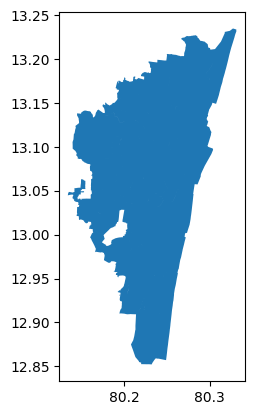

In [16]:
gdf.plot()

This "hole" is normal for this dataset, but let's close it using Geopandas:

In [17]:
from shapely.geometry import Polygon, MultiPolygon

def close_holes(geom):
    if geom.geom_type == "Polygon":
        return Polygon(geom.exterior)

    elif geom.geom_type == "MultiPolygon":
        return MultiPolygon(
            [Polygon(p.exterior) for p in geom.geoms]
        )

    else:
        raise ValueError(f"Unsupported geometry type: {geom.geom_type}")

In [18]:
gdf

,geometry
0,"MULTIPOLYGON Z (((80.18851 12.95828 0, 80.1889..."


In [19]:
dissolved_chennai_copy = gdf.copy()
dissolved_chennai_copy["geometry"] = dissolved_chennai_copy.geometry.apply(close_holes)

<Axes: >

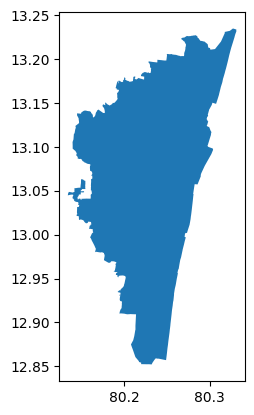

In [20]:
dissolved_chennai_copy.plot()

Save this as a geojson file:

In [21]:
output_path = "chennai_boundary2.geojson"
dissolved_chennai_copy.to_file(output_path, driver="GeoJSON", index=False)

## Reading in the Geojson file and using Folium

In [22]:
filepath_2 = Path('/content/chennai_boundary2.geojson')

<Axes: >

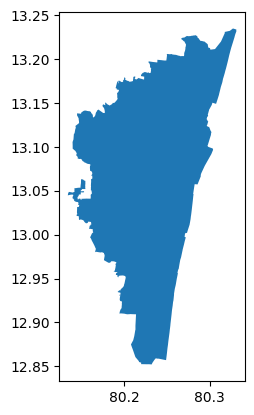

In [23]:
gdf = gpd.read_file(filepath_2)
gdf.plot()

In [24]:
import json
import folium

In [25]:
with open(filepath_2, 'r') as f:
    data = json.load(f)

In [ ]:
m = folium.Map([13.08, 80.27], zoom_start=11)
folium.GeoJson(data).add_to(m)
m


Alternatively, we could have also added the Geopandas dataframe to Folium using the following command:

In [ ]:
folium.GeoJson(gdf).add_to(m)
m